# Baseline BERT Models

In [1]:
# Append the directory containing the src folder to sys.path
import sys

sys.path.append('/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift')

In [2]:
%pip list

Package                       Version
----------------------------- --------------
absl-py                       1.4.0
aioboto3                      12.4.0
aiobotocore                   2.12.3
aiohttp                       3.9.5
aioitertools                  0.11.0
aiosignal                     1.3.1
annotated-types               0.6.0
anyio                         4.3.0
appnope                       0.1.4
argon2-cffi                   23.1.0
argon2-cffi-bindings          21.2.0
arrow                         1.3.0
asttokens                     2.4.1
astunparse                    1.6.3
async-lru                     2.0.4
async-timeout                 4.0.3
attrs                         23.2.0
Babel                         2.15.0
beautifulsoup4                4.12.3
bleach                        6.1.0
boto3                         1.34.69
botocore                      1.34.69
cachetools                    5.3.3
certifi                       2024.2.2
cffi                          1.16.0
c

In [3]:
#%pip install /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl

Processing /Users/lars/Downloads/tensorflow_text-2.15.0-cp310-cp310-macosx_11_0_arm64.whl
tensorflow-text is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
#%pip install -U "tf-models-official==2.15.*"

You should consider upgrading via the '/Users/lars/Documents/test/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Path variables for datasets
directory = "/Users/lars/Documents/Uni/Masterarbeit/Online_Process_Concept_Drift"
path_raw = "/data/raw/"
path_interim = "/data/interim/"
path_processed = "/data/processed/"

In [3]:
import os
import time
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow_text as text
import tensorflow_hub as hub
from tensorflow.keras.callbacks import Callback # type: ignore
from src.data.data_manager import data_loader, save_event_log, delete_dataframes
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.exceptions import UndefinedMetricWarning
import transformers
from transformers import LongformerTokenizer, TFAutoModel, AutoTokenizer

TensorFlow version: 2.15.0


/Users/lars/Documents/test/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("TensorFlow version:", tf.__version__)

print("Transformer version:", transformers.__version__)

print("Tf.text version:", text.__version__)

print("tf.hub: ", hub.__version__)

TensorFlow version: 2.15.0
Transformer version: 4.31.0
Tf.text version: 2.15.0
tf.hub:  0.16.1


In [5]:
#Verify GPU is used

print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPUs available: ", len(gpus))
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU available")

# Verify GPU utilization with a simple computation
with tf.device('/GPU:0'):
    a = tf.random.normal([10000, 10000])
    b = tf.random.normal([10000, 10000])
    start_time = time.time()
    c = tf.matmul(a, b)
    print("GPU computation time: ", time.time() - start_time, "seconds")

TensorFlow version: 2.15.0
GPUs available:  0
No GPU available
GPU computation time:  2.8520641326904297 seconds


In [6]:
train_tensor = data_loader(directory, path_interim, "Helpdesk_train")
val_tensor = data_loader(directory, path_interim, "Helpdesk_val")
test_tensor = data_loader(directory, path_interim, "Helpdesk_test")

In [7]:
# Lookup: Train/Val sequence length for all datasets

#train_max_length_helpdesk = 36
#val_max_length_helpdesk = 32

#train_max_length_bpic2012 = 511
#val_max_length_bpic2012 = 526

#train_max_length_bpic2018 = 242
#val_max_length_bpic2018 = 242

In [8]:
# Lookup: Number of labels per dataset

# helpdesk = 10
# bpic2012 = 24
# bpic2018 = 42

In [9]:
train_tensor

,Prefix_Trace,Next_Activity
0,assign-seriousness,take-in-charge-ticket
1,assign-seriousness take-in-charge-ticket,take-in-charge-ticket
2,assign-seriousness take-in-charge-ticket take-...,resolve-ticket
3,assign-seriousness take-in-charge-ticket take-...,closed
4,assign-seriousness take-in-charge-ticket take-...,end
...,...,...
13170,assign-seriousness,take-in-charge-ticket
13171,assign-seriousness take-in-charge-ticket,wait
13172,assign-seriousness take-in-charge-ticket wait,resolve-ticket
13173,assign-seriousness take-in-charge-ticket wait ...,closed


---
# Code Clean

## Bert Base Model

1. Preprocessing

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

class BERTPreprocessor:
    def __init__(self, default_max_length=512):
        self.preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", trainable=False)
        self.default_max_length = default_max_length
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def calculate_max_length(self, text_inputs):
        processed = self.preprocessor(text_inputs)
        tokenized_lengths = [len(seq) for seq in processed['input_word_ids']]
        self.max_length = min(max(tokenized_lengths), self.default_max_length)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        
        # Dynamically calculate the max length based on the dataset
        self.calculate_max_length(text_inputs)

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Create the dataset directly from text inputs
        dataset = tf.data.Dataset.from_tensor_slices(text_inputs)

        def preprocess_text(text):
            processed = self.preprocessor([text])
            input_word_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_word_ids'], maxlen=self.max_length, padding='post')
            input_mask = tf.keras.preprocessing.sequence.pad_sequences(processed['input_mask'], maxlen=self.max_length, padding='post')
            input_type_ids = tf.keras.preprocessing.sequence.pad_sequences(processed['input_type_ids'], maxlen=self.max_length, padding='post')
            return input_word_ids[0], input_mask[0], input_type_ids[0]

        # Apply preprocessing in batches and in parallel
        dataset = dataset.map(lambda text: tf.py_function(func=preprocess_text, inp=[text], Tout=[tf.int32, tf.int32, tf.int32]),
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
        
        dataset = dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE).cache()

        # Collect the batches and concatenate them into single tensors
        input_word_ids, input_mask, input_type_ids = [], [], []

        for batch in dataset:
            input_word_ids.append(batch[0])
            input_mask.append(batch[1])
            input_type_ids.append(batch[2])

        input_word_ids = tf.concat(input_word_ids, axis=0)
        input_mask = tf.concat(input_mask, axis=0)
        input_type_ids = tf.concat(input_type_ids, axis=0)

        with tf.device('/device:GPU:0'):
            input_word_ids = tf.convert_to_tensor(input_word_ids)
            input_mask = tf.convert_to_tensor(input_mask)
            input_type_ids = tf.convert_to_tensor(input_type_ids)

        preprocessed_text = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids,
            'labels': labels
        }

        return preprocessed_text


In [11]:
preprocessor = BERTPreprocessor()
preprocessor.fit_activity_labels(train_tensor)
bert_input_train = preprocessor.preprocess(train_tensor)
bert_input_val = preprocessor.preprocess(val_tensor)

In [12]:
bert_input_val

{'input_word_ids': <tf.Tensor: shape=(2805, 128), dtype=int32, numpy=
 array([[  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0],
        ...,
        [  101, 19274,  1011, ...,     0,     0,     0],
        [  101, 19274,  1011, ...,     0,     0,     0],
        [  101, 19274,  1011, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(2805, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(2805, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, 

In [13]:
max_length = preprocessor.max_length
max_length

#max_length = 128 # Backup in case Preprocesaor is not loaded

128

In [ ]:
# Save the tokenized sequences as pkl file to avoid need of tokenizing in later sessions

#Train data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_train_input.pkl', 'wb') as file:
    pickle.dump(bert_input_train, file)

#Val data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_val_input.pkl', 'wb') as file:
    pickle.dump(bert_input_val, file)

In [14]:
# Load the tokenized sequences again

#Train data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_train_input.pkl', 'rb') as file:
    loaded_data_dict_train = pickle.load(file)

#Val data
with open('/Users/lars/Documents/test/data/processed/Helpdesk_val_input.pkl', 'rb') as file:
    loaded_data_dict_val = pickle.load(file)

# Ensure the tensors are converted back correctly
loaded_data_dict_train = {key: tf.convert_to_tensor(value) for key, value in loaded_data_dict_train.items()}

loaded_data_dict_val = {key: tf.convert_to_tensor(value) for key, value in loaded_data_dict_val.items()}


In [15]:
loaded_data_dict_train

{'input_word_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
 array([[  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0],
        ...,
        [  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0],
        [  101, 23911,  1011, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(13175, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

2. Create and fine-tune BERT Base model

In [ ]:
# Set evnviroment variables to reduce mmodel's memory usage and increase efficency

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Enable mixed precision for better performance and reduced memory usage
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [16]:
# Define a class to build the BERT model

class BERTModelBuilder:
    def __init__(self, preprocessor_url, encoder_url, num_classes, max_length=512):
        self.preprocessor_url = preprocessor_url
        self.encoder_url = encoder_url
        self.num_classes = num_classes
        self.max_length = max_length

    def create_model(self):
        preprocessor = hub.KerasLayer(self.preprocessor_url, name='preprocessing')
        encoder = hub.KerasLayer(self.encoder_url, trainable=True, name='BERT_encoder')

        input_word_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.layers.Input(shape=(self.max_length,), dtype=tf.int32, name='input_type_ids')

        encoder_inputs = {
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        }
        encoder_outputs = encoder(encoder_inputs)
        pooled_output = encoder_outputs['pooled_output']

        dropout = tf.keras.layers.Dropout(rate=0.3)(pooled_output)
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype='float32',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        return model

In [17]:
# Adding custom callback class to retrieve F1 Score, Precision and Recall

class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        val_pred = self.model.predict(val_data[0])
        val_pred = tf.argmax(val_pred, axis=1)
        val_true = val_data[1]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(val_true, val_pred, average='weighted')
            precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
            recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)

        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')

In [18]:
# Set model parameters

# URLs for the BERT model and preprocessor
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Number of classes
num_classes = len(preprocessor.activity_to_label)

#num_classes = 10  # Backup in case Preprocessor class is not loaded

batch_size = 32

In [19]:
# Initialize and create model

model_builder = BERTModelBuilder(preprocessor_url=tfhub_handle_preprocess, 
                                 encoder_url=tfhub_handle_encoder, 
                                 num_classes=num_classes,
                                 max_length=max_length)  # Use original max_length

model = model_builder.create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

In [20]:
# Prepare dataset and ensure that data is in appropriate formate to be used as input for BERT base

train_data = {
    'input_mask': bert_input_train['input_mask'],
    'input_type_ids': bert_input_train['input_type_ids'],
    'input_word_ids': bert_input_train['input_word_ids']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_mask': bert_input_val['input_mask'],
    'input_type_ids': bert_input_val['input_type_ids'],
    'input_word_ids': bert_input_val['input_word_ids'],
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Function to ensure labels are one-dimensional
def ensure_one_dimensional(labels):
    if len(labels.shape) == 2 and labels.shape[1] == 1:
        labels = tf.squeeze(labels, axis=-1)
    return labels

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

After ensuring one-dimensional, shape of train_labels: (13175,)
After ensuring one-dimensional, shape of val_labels: (2805,)


In [ ]:
# Add custom callback metrics to model and fine-tune it

# Train the model with the custom metrics callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallback(validation_data=(val_data, val_labels))
history_helpdesk = model.fit(
    train_dataset,
    epochs=5,  # Increase the number of epochs
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)

In [ ]:
# Save fine-tuned model and training history

# Save the trained model with a specific name
model_name_helpdesk = "bert_model_helpdesk"
model.save(f'/Users/lars/Documents/test/models/models_pretrained/{model_name_helpdesk}')

# Save the training history
import pickle
with open(f'/Users/lars/Documents/test/models/models_pretrained/history_helpdesk.pkl', 'wb') as file:
    pickle.dump(history_helpdesk.history, file)

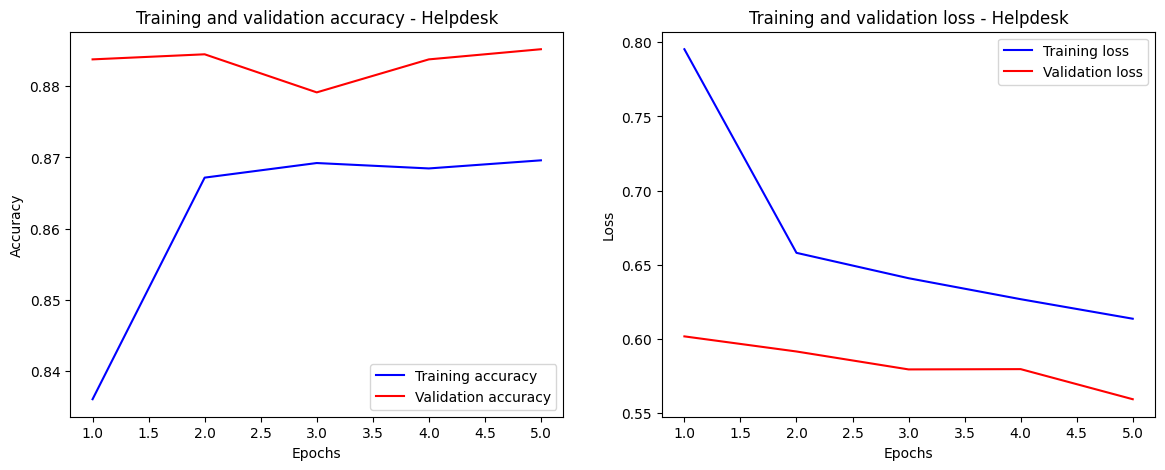

In [22]:
#Re-load fine-tuned model and training history and plot accuracy and loss

#Helpdesk
# Load the saved model
model_name1 = "bert_model_helpdesk"
#loaded_model = tf.keras.models.load_model(f'/Users/lars/Documents/test/models/models_pretrained/{model_name1}')

# Load the training history
with open('/Users/lars/Documents/test/models/models_pretrained/history_helpdesk.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Verify the loaded model
#loaded_model.summary()

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "Helpdesk")


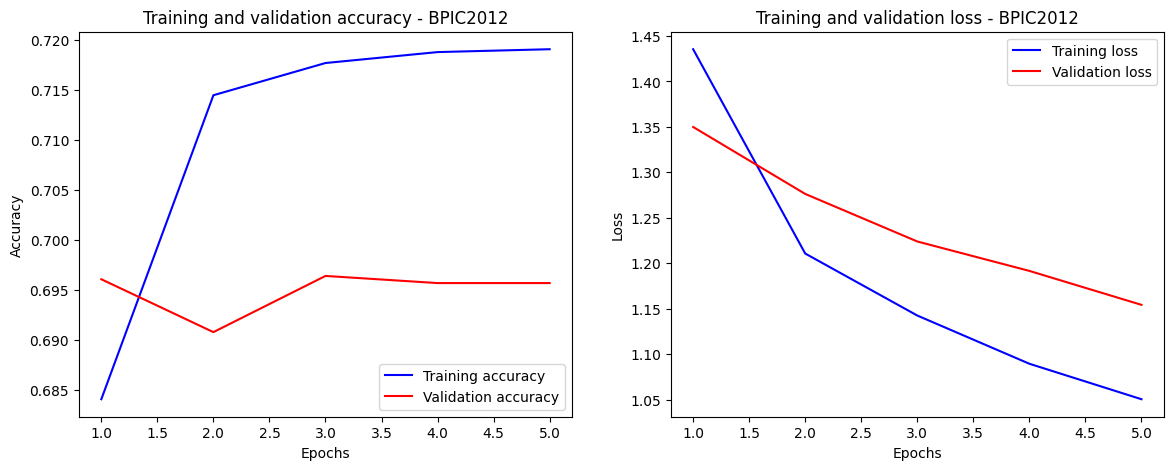

In [23]:
#BPIC2012
# Load the saved model
#model_name2 = "bert_base_model_bpic2012"
#loaded_model = tf.keras.models.load_model(f'/Users/lars/Documents/test/models/models_pretrained/{model_name2}')

# Load the training history
with open('/Users/lars/Documents/test/models/models_pretrained/history_bpic2012.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "BPIC2012")

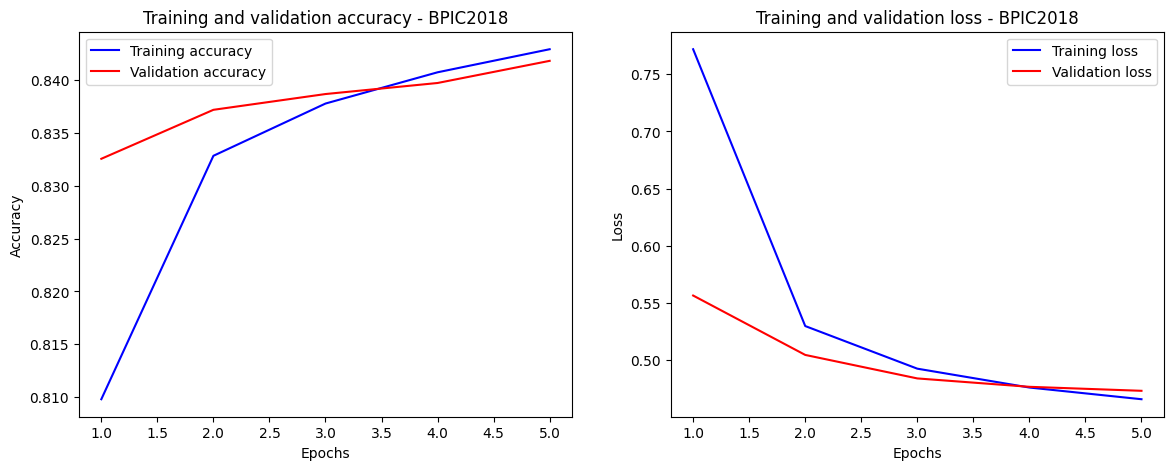

In [24]:
#BPIC2018
# Load the saved model
#model_name3 = "bert_base_model_bpic2018"
#loaded_model = tf.keras.models.load_model(f'/Users/lars/Documents/test/models/models_pretrained/{model_name3}')

# Load the training history
with open('/Users/lars/Documents/test/models/models_pretrained/history_bpic2018.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "BPIC2018")

## LongBERT

1. Preprocessor

In [25]:
class LongformerPreprocessor:
    def __init__(self, model_name='allenai/longformer-base-4096', default_max_length=4096):
        self.tokenizer = LongformerTokenizer.from_pretrained(model_name)
        self.max_length = default_max_length
        self.activity_to_label = {}
        self.label_to_activity = {}
        self.next_label_index = 0

    def fit_activity_labels(self, df):
        activities = df['Next_Activity'].unique()
        self.activity_to_label = {activity: idx for idx, activity in enumerate(activities)}
        self.label_to_activity = {idx: activity for activity, idx in self.activity_to_label.items()}
        self.next_label_index = len(activities)

    def preprocess(self, df):
        text_inputs = df['Prefix_Trace'].tolist()
        

        labels = []
        for next_activity in df['Next_Activity']:
            if next_activity not in self.activity_to_label:
                self.activity_to_label[next_activity] = self.next_label_index
                self.label_to_activity[self.next_label_index] = next_activity
                self.next_label_index += 1
            labels.append(self.activity_to_label[next_activity])

        labels = tf.convert_to_tensor(labels)

        # Tokenize the text inputs
        encodings = self.tokenizer(text_inputs, padding='max_length', max_length=self.max_length, return_tensors='tf')

        # Check for any out-of-bounds token IDs
        input_ids = encodings['input_ids']
        vocab_size = self.tokenizer.vocab_size
        if tf.reduce_max(input_ids) >= vocab_size:
            print(f"Max token ID: {tf.reduce_max(input_ids)}")
            print(f"Vocabulary size: {vocab_size}")
            raise ValueError("Some token IDs are out of bounds of the tokenizer vocabulary size.")

        preprocessed_text = {
            'input_ids': input_ids,
            'attention_mask': encodings['attention_mask'],
            'labels': labels
        }

        return preprocessed_text, self.max_length  # Return the dynamically calculated max_length


In [28]:
# Initialize the preprocessor and preprocess the data
preprocessor = LongformerPreprocessor(model_name='allenai/longformer-base-4096', default_max_length=36)
bert_input_train, train_max_length = preprocessor.preprocess(train_tensor)
bert_input_val, val_max_length = preprocessor.preprocess(val_tensor)

In [29]:
print(train_max_length)
print(val_max_length)

36
36


In [ ]:
# Lookup: Train/Val sequence length for all datasets

#train_max_length_helpdesk = 36
#val_max_length_helpdesk = 32

#train_max_length_bpic2012 = 511
#val_max_length_bpic2012 = 526

#train_max_length_bpic2018 = 242
#val_max_length_bpic2018 = 242

In [ ]:
# Save the preprocessed datasets for the LongBERT model

# Convert tensors to numpy arrays to save them in a pkl file
bert_input_train_numpy = {key: tensor.numpy() for key, tensor in bert_input_train.items()}
bert_input_val_numpy = {key: tensor.numpy() for key, tensor in bert_input_val.items()}

# Save the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_train_input.pkl', 'wb') as file:
    pickle.dump(bert_input_train_numpy, file)

with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_val_input.pkl', 'wb') as file:
    pickle.dump(bert_input_val_numpy, file)

In [ ]:
# Load preprocessed datasets for LongBERT back into enviroment

# Load the dictionary using pickle
with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_train_input.pkl', 'rb') as file:
    bert_input_train_numpy = pickle.load(file)

with open('/Users/lars/Documents/test/data/processed/Long_bpic2018_val_input.pkl', 'rb') as file:
    bert_input_val_numpy = pickle.load(file)

# Convert NumPy arrays back to TensorFlow tensors
bert_input_train = {key: tf.convert_to_tensor(value) for key, value in bert_input_train_numpy.items()}
bert_input_val = {key: tf.convert_to_tensor(value) for key, value in bert_input_val_numpy.items()}

# Print the loaded data to confirm the conversion
print(bert_input_train)
print(bert_input_val)

In [ ]:
# Setup enviroment parameters to optimize memory usage and efficency

# Clear any existing GPU memory state
tf.keras.backend.clear_session()

# Set the environment variable for GPU memory management
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Reduce TensorFlow logging verbosity
tf.get_logger().setLevel('ERROR')

In [5]:
# Define a class to build the LongBERT model

class LongformerModelBuilder:
    def __init__(self, model_name, num_classes):
        self.model_name = model_name
        self.num_classes = num_classes

    def create_model(self, max_length):
        # Ensure TensorFlow uses the GPU if available
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
            except RuntimeError as e:
                print(e)

        # Load the model
        encoder = TFAutoModel.from_pretrained(self.model_name)

        input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

        encoder_outputs = encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = encoder_outputs.last_hidden_state[:, 0, :]

        dropout = tf.keras.layers.Dropout(rate=0.3)(pooled_output)
        output = tf.keras.layers.Dense(self.num_classes, activation='softmax', dtype='float32',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

        model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
        
        model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5),
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        return model


In [6]:
# Adding custom callback class to retrieve F1 Score, Precision and Recall

class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_data = self.validation_data
        val_pred = self.model.predict(val_data)
        val_pred = tf.argmax(val_pred, axis=1)
        val_true = tf.convert_to_tensor(val_labels, dtype=tf.int32)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UndefinedMetricWarning)
            f1 = f1_score(val_true, val_pred, average='weighted')
            precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
            recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)

        print(f' — val_f1: {f1:.4f} — val_precision: {precision:.4f} — val_recall: {recall:.4f}')


In [7]:
# Set model parameters

max_length = 36
num_classes = 10
batch_size=4

In [8]:
# Initialize the model and print summary

model_builder = LongformerModelBuilder(model_name='allenai/longformer-base-4096', num_classes=num_classes)
model = model_builder.create_model(max_length=max_length)
model.summary()

/Users/lars/Documents/test/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some layers from the model checkpoint at allenai/longformer-base-4096 were not used when initializing TFLongformerModel: ['lm_head']
- This IS expected if you are initializing TFLongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFLongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFLongformerModel were initialized from the model checkpoint at allenai/lon

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 36)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 36)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_longformer_model (TFLon  TFLongformerBaseModelOutpu   1486594   ['input_ids[0][0]',           
 gformerModel)               tWithPooling(last_hidden_s   56         'attention_mask[0][0]']      
                             tate=(None, 36, 768),                                            

In [ ]:
# Prepare dataset and ensure that data is in appropriate formate to be used as input for BERT base

train_data = {
    'input_ids': bert_input_train['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_train['attention_mask']
}

train_labels = bert_input_train['labels']

val_data = {
    'input_ids': bert_input_val['input_ids'],  # Assuming input_word_ids correspond to input_ids
    'attention_mask': bert_input_val['attention_mask']
}

val_labels = bert_input_val['labels']

# Ensure labels are in the shape (None,) and integer-encoded
train_labels = tf.squeeze(train_labels)
val_labels = tf.squeeze(val_labels)

# Function to ensure labels are one-dimensional
def ensure_one_dimensional(labels):
    if len(labels.shape) == 2 and labels.shape[1] == 1:
        labels = tf.squeeze(labels, axis=-1)
    return labels

# Apply the function to labels
train_labels = ensure_one_dimensional(train_labels)
val_labels = ensure_one_dimensional(val_labels)

# Confirm the shapes again
print(f"After ensuring one-dimensional, shape of train_labels: {train_labels.shape}")
print(f"After ensuring one-dimensional, shape of val_labels: {val_labels.shape}")

# Shuffle the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(buffer_size=len(train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# No need to shuffle the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Add custom callback metrics to model and fine-tune it

# Define early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

metrics_callback = MetricsCallback(validation_data=val_dataset)

# Assuming you have defined your model (e.g., Longformer model)
history_helpdesk = model.fit(
    train_dataset,
    epochs=5,  # Increase the number of epochs if necessary
    validation_data=val_dataset,
    callbacks=[metrics_callback, early_stopping_callback]
)

In [ ]:
# Save the trained model with a specific name
model_name = "bert_long_model_helpdesk"
#model.save(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Save the training history
import pickle
with open(f'/Users/lars/Documents/test/models/models_pretrained/history_bpic2012_long.pkl', 'wb') as file:
    pickle.dump(history_helpdesk.history, file)


In [ ]:
model_save_path = '/home/lars.gsaenger/test/models/models_pretrained/bert_long_model_bpic2012/bert_long_model_bpic2012_weights.h5'
model.save_weights(model_save_path)

model_json = model.to_json()
model_architecture_path = '/home/lars.gsaenger/test/models/models_pretrained/bert_long_model_bpic2012/bert_long_model_bpic2012_architecture.json'
with open(model_architecture_path, 'w') as json_file:
    json_file.write(model_json)

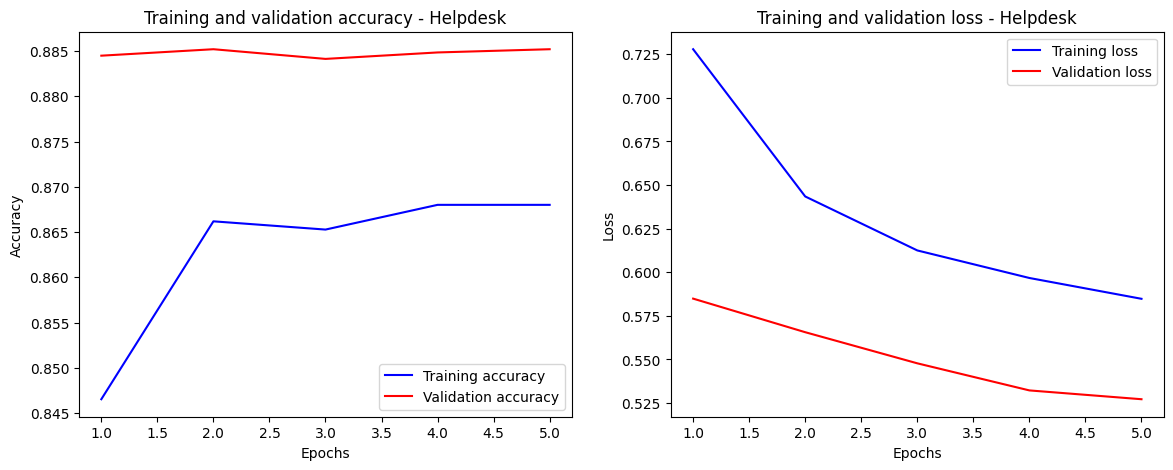

In [10]:
#Helpdesk
# Load the saved model
#loaded_model = tf.keras.models.load_model(f'/home/lars.gsaenger/test/models/models_pretrained/{model_name}')

# Load the training history
with open('/Users/lars/Documents/test/models/models_pretrained/history_helpdesk_long.pkl', 'rb') as file:
    history_helpdesk = pickle.load(file)

# Function to plot training history
def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history_helpdesk, "Helpdesk")

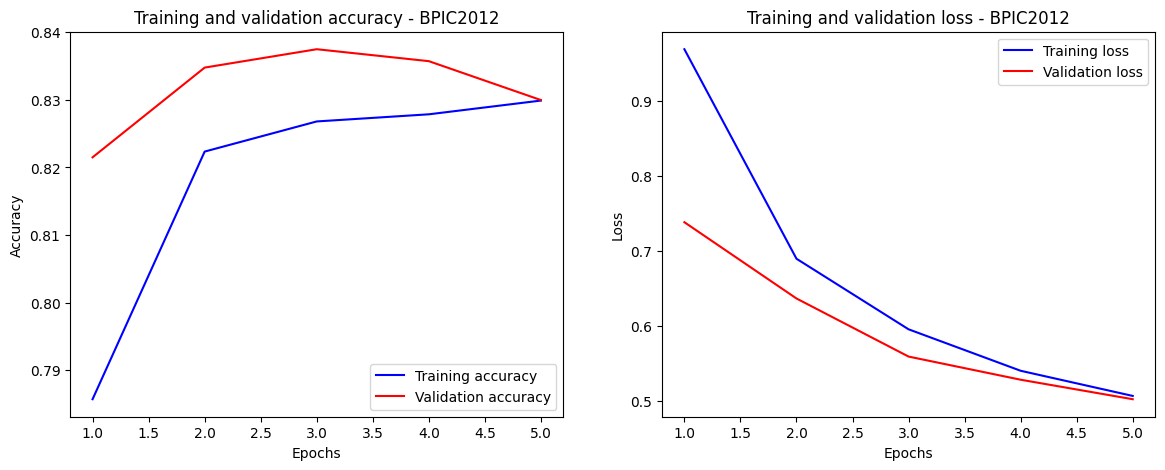

In [11]:
#BPIC2012

with open('/Users/lars/Documents/test/models/models_pretrained/history_bpic2012_long.pkl', 'rb') as file:
    history_bpic2012 = pickle.load(file)
import matplotlib.pyplot as plt

def plot_training_history(history, title):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title(f'Training and validation accuracy - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss - {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_bpic2012, "BPIC2012")

---

## BERT Architecture Visuals

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                            

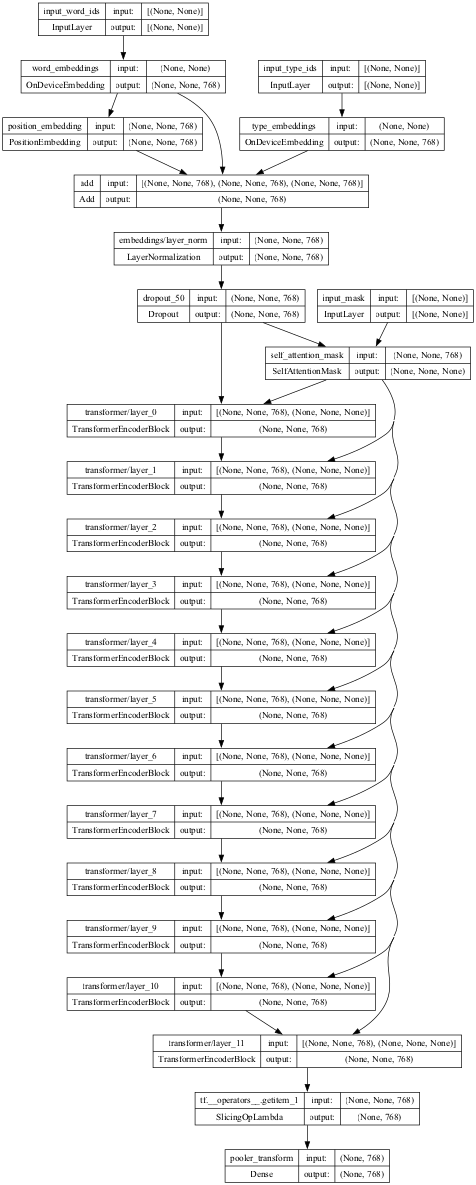

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_models as tfm

def create_detailed_bert_model(num_classes, max_length=128):
    # Define the input layers for tokenized inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_type_ids")

    # Define the encoder configuration
    config_dict = {
        'vocab_size': 30522,
        'hidden_size': 768,
        'num_hidden_layers': 12,
        'num_attention_heads': 12,
        'intermediate_size': 3072,
        'hidden_act': 'gelu',
        'hidden_dropout_prob': 0.1,
        'attention_probs_dropout_prob': 0.1,
        'max_position_embeddings': 512,
        'type_vocab_size': 2,
        'initializer_range': 0.02,
        'layer_norm_eps': 1e-12
    }

    encoder_config = tfm.nlp.encoders.EncoderConfig({
        'type': 'bert',
        'bert': config_dict
    })

    # Build the BERT encoder
    bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)

    # Pass the inputs to the BERT layer
    bert_outputs = bert_encoder([input_word_ids, input_mask, input_type_ids])
    
    # Get the pooled output from BERT
    pooled_output = bert_outputs['pooled_output']
    
    # Add a dropout layer for regularization
    dropout = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
    
    # Output layer for classification
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name="classifier")(dropout)

    # Create the model
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    
    return model, bert_encoder

# Example usage
num_classes = 10  # Replace with the actual number of classes

# Create the detailed BERT model
model, bert_encoder = create_detailed_bert_model(num_classes)

# Print the model summary
model.summary()

# Plot the detailed model architecture
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)
